# Predict velocity values using MORAI

This notebook uses Masked Encoder-based Universal Time Series Forecasting Transformer (Moirai), a large-language model (LLM) created by Salesforce, to predit velocity values at ZI. Moirai seeks to close gaps in time series forecasting by learning the frequencies of test datasets using automatically varying patch sizes (a patch being a series of consecutive time points) - larger patches for higher frequency data.

Moirai-moe, the second version of Moirai, uses a decoder-only architecture which is able to run faster than Moirai and in parallel. The model also uses a mixture-of-experts (MOE) instead of the original patch layers. MOE, instead of labeling a patch with an arbitrary frequency, is able to route the patch to the best-suited expert which can handle differing frequencies in the same patch.

---

### 1. Load packages and dataset

Here you can choose Moirai or Moirai-moe. We will assign a label to each time series contained in a dataframe. In this example, there is only one time series in the dataframe. Additionally, the data should be able to be converted to a GluonTS dataset required for Moirai.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
%matplotlib ipympl

MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}

In [17]:
# Load data
point_name = 'middle' # point name: choose from {'upstream', 'middle', 'terminus'}
df = pd.read_csv('../data/ai_ready/' + point_name + '_timeseries.csv', parse_dates=True)

# Preprocess data
df.set_index(pd.to_datetime(df['time']), inplace=True)
df.drop(columns=['time'], inplace=True)
df.drop(columns=['series'], inplace=True)
df = df.rename(columns={'velocity': 'target'})

# Resample and interpolate
df['timestamp'] = pd.to_datetime(df.index)  # Ensure date is datetime type
df = df.set_index('timestamp').resample('6D').mean(numeric_only=True)  # Resample to every 6 days frequency
df = df.interpolate()  # Interpolate missing values
df['item_id'] = 'A'
df.head()

,target,item_id
timestamp,,
2015-01-30,779.535340,A
2015-02-05,758.979735,A
2015-02-11,738.424130,A
2015-02-17,738.549458,A
2015-02-23,738.674785,A


### 2. Configure model settings

SIZE: model size, select the model size of Moirai to perform inference with

PDT: prediction length, how many time steps to predict into the future

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

TEST: test set length, number of time steps to hold out for test set

In [18]:
SIZE = "base"  # model size: choose from {'small', 'base', 'large'}
PDT = 20  # prediction length: any positive integer
CTX = 30  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer
TEST = 150  # test set length: any positive integer

In [19]:
# Convert data into GluonTS dataset
ds = PandasDataset.from_long_dataframe(df, target="target", item_id="item_id", freq="6D")

# Split into train/test set
train, test_template = split(
    ds, offset=-TEST
)  # assign last TEST time steps as test set

# Construct rolling window evaluation
test_data = test_template.generate_instances(
    prediction_length=PDT,  # number of time steps for each prediction
    windows=TEST // PDT,  # number of windows in rolling window evaluation
    distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
)

Ensure the `SIZE` above matches the pretrained model path in the `module` parameter.

In [20]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-base"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-base"),
        prediction_length=PDT,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=1,
        feat_dynamic_real_dim=ds.num_feat_dynamic_real,
        past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

### 3. Make predictions and plot

Based on the context length, Moirai will make and plot predictions on different subsets of the time series for a given context length. Multiple plots will be output, given that the context length is less than the size of the data.

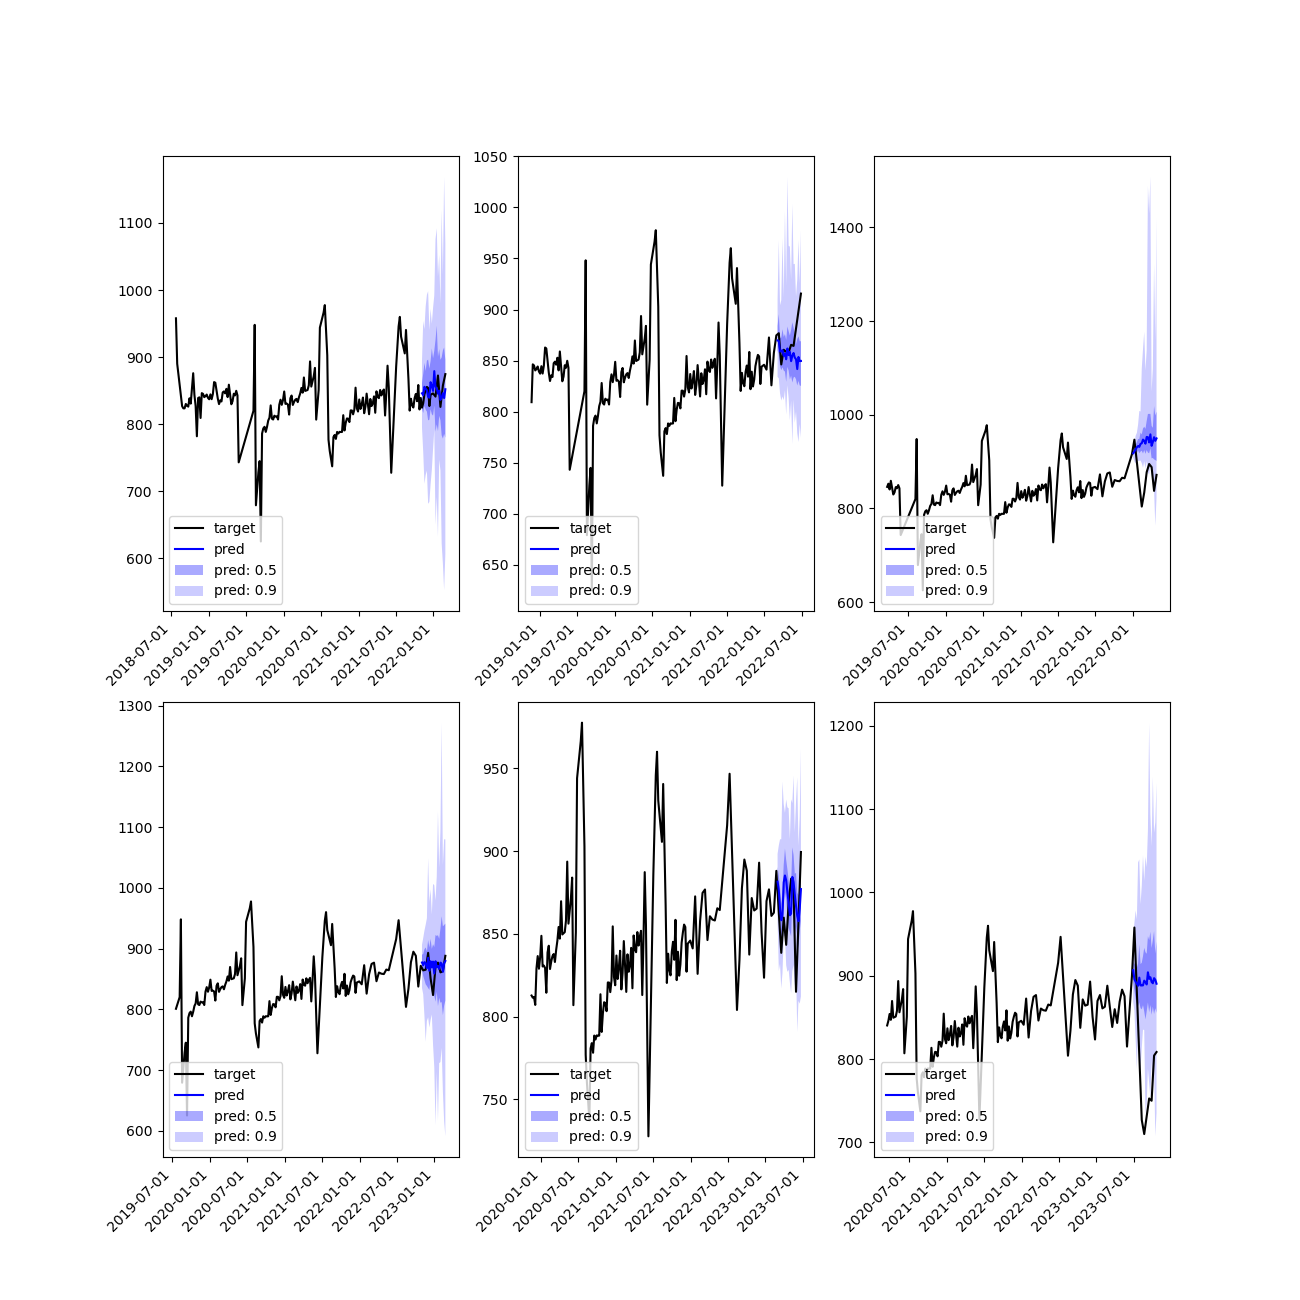

In [21]:
# Make predictions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 13))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)

### 4. Calculate metrics

Calculate the MAE and RMSE values for the predictions.

In [22]:
# Collect all true values and predictions
true_values = []
predictions = []

for label, forecast in zip(test_data.label, forecasts):
    true_values.extend(label['target'])
    predictions.extend(forecast.mean)

# Convert to numpy arrays
true_values = np.array(true_values)
predictions = np.array(predictions)

# Calculate MAE and RMSE
mae = mean_absolute_error(true_values, predictions)
rmse = np.sqrt(mean_squared_error(true_values, predictions))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 36.95083965722656
Root Mean Squared Error (RMSE): 47.95768918073869
